In [46]:
print('Notes of lecture 3\nBuilding makemore Part 3: Activations & Gradients, BatchNorm')

Notes of lecture 3
Building makemore Part 3: Activations & Gradients, BatchNorm


In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline


In [48]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [49]:
len(words)

32033

In [50]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos)

print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [51]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [52]:
# MLP revisited

n_embd = 10      # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *0.1
b1 = torch.randn(n_hidden, generator=g) *0
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) *0
# we multiply b1,b2 by 0 to ultimately scale the logits down
# we multiply w1,W2 by 0.1 to scale it down
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

11897


In [53]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]                           # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1            # hidden layer pre-activation
    h = torch.tanh(hpreact)               # hidden layer
    logits = h @ W2 + b2                  # output layer
    loss = F.cross_entropy(logits, Yb)    # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.5445
  10000/ 200000: 2.1220
  20000/ 200000: 2.2625
  30000/ 200000: 2.4469
  40000/ 200000: 1.9240
  50000/ 200000: 2.2746
  60000/ 200000: 2.3458
  70000/ 200000: 2.1420
  80000/ 200000: 2.2136
  90000/ 200000: 2.0496
 100000/ 200000: 1.8513
 110000/ 200000: 2.2246
 120000/ 200000: 1.8360
 130000/ 200000: 2.3915
 140000/ 200000: 2.2271
 150000/ 200000: 2.1798
 160000/ 200000: 1.8160
 170000/ 200000: 1.8098
 180000/ 200000: 1.8844
 190000/ 200000: 1.8678


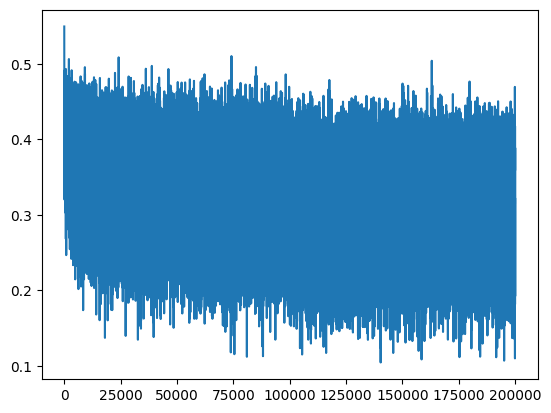

In [ ]:
plt.plot(lossi)
#You can see that the plot of the loss dosent have a hockey shape appearance because the loss started small

In [56]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte),
    }[split]

    emb = C[X]                                   # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)          # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)              # (N, n_hidden)
    logits = h @ W2 + b2                          # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.0500078201293945
val 2.106783151626587


In [57]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...

    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]        # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word

carmahzabelle.
khy.
mili.
thil.
skanden.
jazhitn.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quinthorlin.
alvin.
quinterra.
jaryxi.
jaxenni.
sabee.
deci.


In [58]:
#issue 1 the initial loss
#This nwtwork is very improperly configered 
#in training a neural net you will have a rough idea of what your initial loss will look like
#in our case the initial loss is 26.0
# When initializing parameters, we want all characters to start with equal logits so that, after softmax, they have a uniform and non-zero probability distribution. or getting logits getting closer to zero will also be fine
#in neural networks we dont want weights to be zero because if they become zero the logits will be zero and there will be no gradient descent
# All weights start equal (zero)
# All neurons see the same gradients
# Then:
# They remain clones of each other forever
#the number we expext is -
-torch.tensor(1/27).log()

tensor(3.2958)

In [59]:
# so yeah our initial loss hould be around 3.29 not 26
# we are essentially wasting first few iteration of optimization purely on squashing down the weights and stuff